In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
processed_df = pd.read_pickle("data/processed_recipes.pkl")
processed_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,allergens,processed_name,processed_instructions,processed_description,allergen_type,processed_ingredients,combined_all_contexts,combined_name_ingredients
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",[yogurt],doddapatre tambuli karpooravalli thayir pachadi,doddapatre tambuli doddapatre leave dry towel ...,doddapatre tambuli popular healing cold yoghur...,[Dairy],indian borage doddapatre curd dahi yogurt cumi...,doddapatre tambuli karpooravalli thayir pachad...,doddapatre tambuli karpooravalli thayir pachad...
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",[fish],fish tandoori,fish tandoori head fin inside fish many horizo...,fish tandoori delicious chicken tandoori tando...,[Fish and Shellfish],fish curd dahi yogurt onion green chilli tando...,fish tandoori fish curd dahi yogurt onion gree...,fish tandoori fish curd dahi yogurt onion gree...
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",[peanut],arbi shimla mirch sabzi colocasia capsicum sabzi,arbi shimla mirch sabzi arbi pressure pressure...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]",colocasia root arbi green bell pepper capsicum...,arbi shimla mirch sabzi colocasia capsicum sab...,arbi shimla mirch sabzi colocasia capsicum sab...
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...","[sesame, mustard, peanut]",ambur style brinjal curry,ambur style brinjal curry oil heavy bottomed o...,brinjal curry different way different region s...,"[Legumes and Seeds, Tree Nuts and Peanuts]",brinjal baingan eggplant onion ginger garlic p...,ambur style brinjal curry brinjal baingan eggp...,ambur style brinjal curry brinjal baingan eggp...
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango raw, jaggery, turmeric powder haldi, ta...",[sesame],mavinakayi menasinakai curry raw mango coconut...,mangalorean mavinakayi menasinakai curry raw m...,mangalorean mavinakayi menasinakai curry raw m...,[Legumes and Seeds],mango raw jaggery turmeric powder haldi tamari...,mavinakayi menasinakai curry raw mango coconut...,mavinakayi menasinakai curry raw mango coconut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,Spinach Oats Vada Recipe,"Spinach Leaves (Palak), Chana dal (Bengal Gram...",Spinach Oats Vada Recipe is a healthy twist to...,"To prepare Spinach Oats Vada Recipe, in a larg...",South Indian,Snack,Vegetarian,50.0,~1 hour,"[spinach leave palak, chana dal bengal gram da...",[oats],spinach oats vada,spinach oats vada large mixing ingredient vada...,spinach oats vada healthy twist vada superfood...,[Grains and Gluten],spinach leave palak chana dal bengal gram dal ...,spinach oats vada spinach leave palak chana da...,sp

In [3]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       9496 non-null   object 
 1   ingredients                9496 non-null   object 
 2   description                9496 non-null   object 
 3   instructions               9496 non-null   object 
 4   cuisine                    9488 non-null   object 
 5   course                     9462 non-null   object 
 6   diet                       9462 non-null   object 
 7   prep_time                  9487 non-null   float64
 8   categorized_prep_time      9496 non-null   object 
 9   cleaned_ingredients        9496 non-null   object 
 10  allergens                  9496 non-null   object 
 11  processed_name             9496 non-null   object 
 12  processed_instructions     9496 non-null   object 
 13  processed_description      9496 non-null   objec

Train NMF model on TF-IDF and Count Vectorizers and find the best number of topics using coherence scores 

In [4]:
def compute_coherence_scores_nmf(texts, vectorizer, num_topics_range):
    coherence_scores = []
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in texts for Gensim's coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        nmf_model = NMF(n_components=num_topics, random_state=42)
        topic_matrix = nmf_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()


    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")
    
    return coherence_scores, best_num_topics

Compare the performance of NMF model on TF-IDF vectorizer using "processed_name", "combined_name_ingredients", and "combined_all_contexts" columns seperately

Number of Topics: 1, Coherence Score: 0.2872691998341319
Number of Topics: 2, Coherence Score: 0.3590390502531612
Number of Topics: 3, Coherence Score: 0.39400529564033865


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 4, Coherence Score: 0.3528077810414657
Number of Topics: 5, Coherence Score: 0.35372339451325585
Number of Topics: 6, Coherence Score: 0.37733202060613036
Number of Topics: 7, Coherence Score: 0.3635066753472205
Number of Topics: 8, Coherence Score: 0.4049985898234273
Number of Topics: 9, Coherence Score: 0.381825328323548
Number of Topics: 10, Coherence Score: 0.3910233163155471


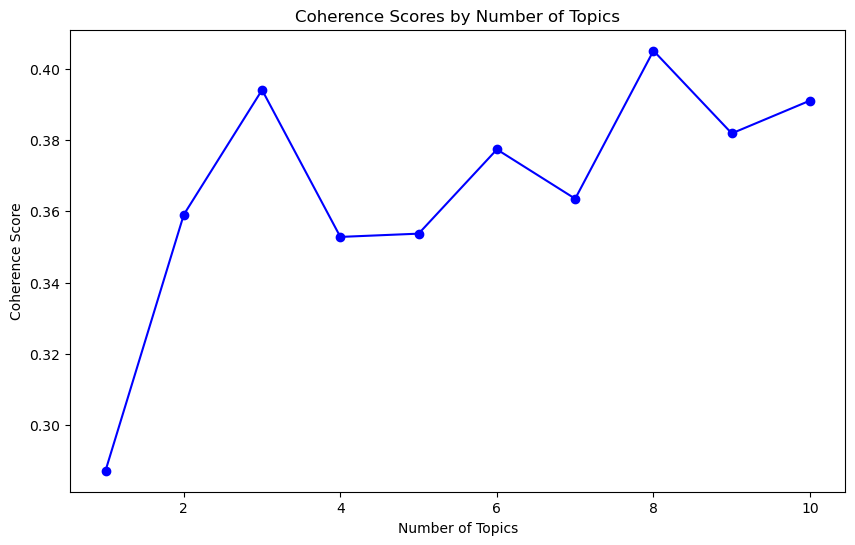

Best Number of Topics: 8 with Coherence Score: 0.4049985898234273


In [5]:
name_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['processed_name'], TfidfVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.6915303353460391
Number of Topics: 2, Coherence Score: 0.8128603139298094
Number of Topics: 3, Coherence Score: 0.8068159393962664
Number of Topics: 4, Coherence Score: 0.7853725872120834
Number of Topics: 5, Coherence Score: 0.8158667515434379
Number of Topics: 6, Coherence Score: 0.8209727667113239
Number of Topics: 7, Coherence Score: 0.8079425137830633
Number of Topics: 8, Coherence Score: 0.8058520789614877
Number of Topics: 9, Coherence Score: 0.8010703514938707
Number of Topics: 10, Coherence Score: 0.80415215349124


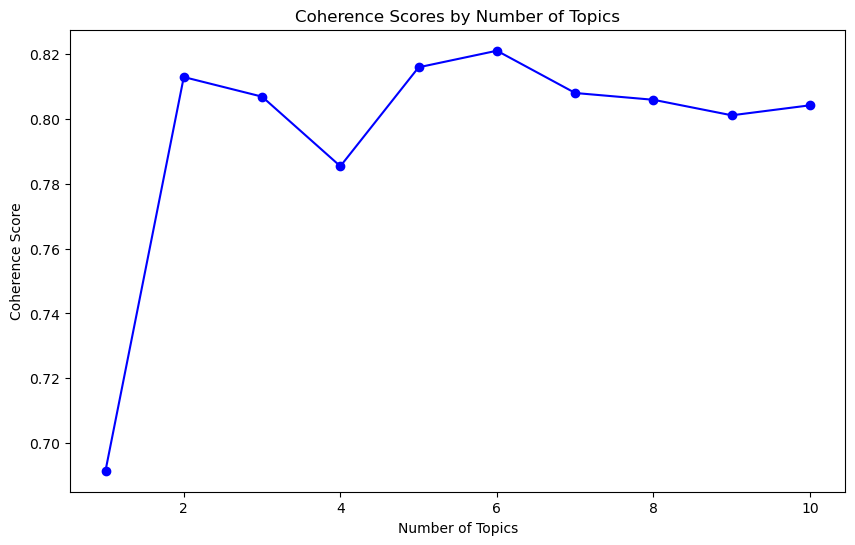

Best Number of Topics: 6 with Coherence Score: 0.8209727667113239


In [6]:
name_ingredients_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_name_ingredients'], TfidfVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.5949663579641742
Number of Topics: 2, Coherence Score: 0.601512110434862
Number of Topics: 3, Coherence Score: 0.6094499931235792
Number of Topics: 4, Coherence Score: 0.6105299608896239
Number of Topics: 5, Coherence Score: 0.6376616980870949
Number of Topics: 6, Coherence Score: 0.6571361295400627
Number of Topics: 7, Coherence Score: 0.6437939252039808
Number of Topics: 8, Coherence Score: 0.6774505684524799
Number of Topics: 9, Coherence Score: 0.661703258940644


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 10, Coherence Score: 0.645464290332169


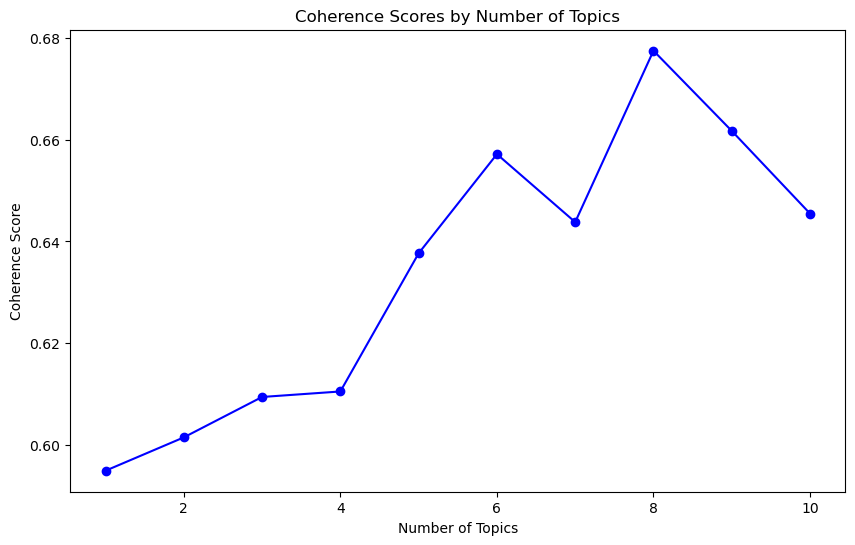

Best Number of Topics: 8 with Coherence Score: 0.6774505684524799


In [ ]:
all_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_all_contexts'], TfidfVectorizer(), range(1, 15,1))

Compare the performance of NMF model on Count vectorizer using using "processed_name", "combined_name_ingredients", and "combined_all_contexts" columns seperately

Number of Topics: 15, Coherence Score: 0.3632625577290341
Number of Topics: 16, Coherence Score: 0.3988508078560684
Number of Topics: 17, Coherence Score: 0.3914812650141221
Number of Topics: 18, Coherence Score: 0.40739809171320773
Number of Topics: 19, Coherence Score: 0.40483608860125925
Number of Topics: 20, Coherence Score: 0.3955352392211415
Number of Topics: 21, Coherence Score: 0.39858491400115365
Number of Topics: 22, Coherence Score: 0.39325641665148386
Number of Topics: 23, Coherence Score: 0.4067332915269558
Number of Topics: 24, Coherence Score: 0.4157865542399403
Number of Topics: 25, Coherence Score: 0.41103903567978234
Number of Topics: 26, Coherence Score: 0.41111983829446747
Number of Topics: 27, Coherence Score: 0.40760293296319394
Number of Topics: 28, Coherence Score: 0.4068662220181093
Number of Topics: 29, Coherence Score: 0.40267163017986424


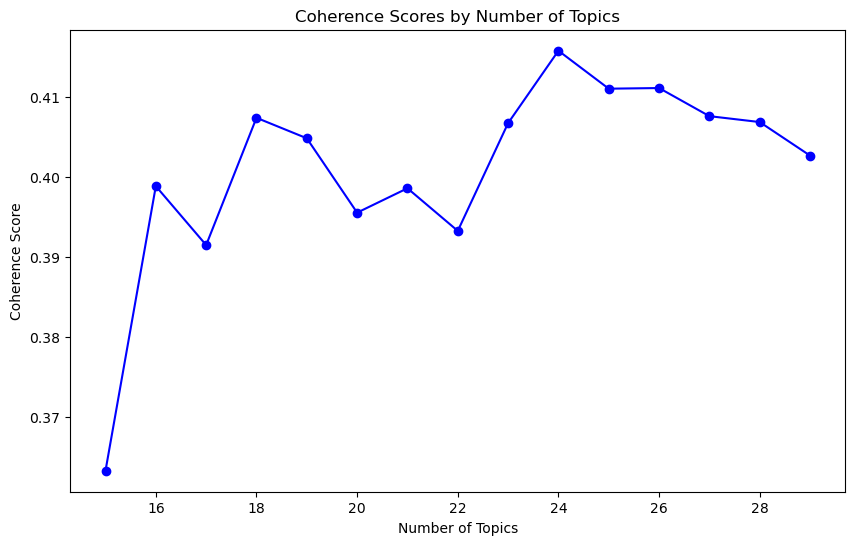

Best Number of Topics: 24 with Coherence Score: 0.4157865542399403


In [10]:
name_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['processed_name'],  CountVectorizer(), range(15, 30,1))

Number of Topics: 1, Coherence Score: 0.7210354061989326
Number of Topics: 2, Coherence Score: 0.7590411254122914
Number of Topics: 3, Coherence Score: 0.734191819430677
Number of Topics: 4, Coherence Score: 0.7388406279301701
Number of Topics: 5, Coherence Score: 0.7603417223816524
Number of Topics: 6, Coherence Score: 0.7478358129034559
Number of Topics: 7, Coherence Score: 0.7635773058132608
Number of Topics: 8, Coherence Score: 0.744750380482756
Number of Topics: 9, Coherence Score: 0.713640807273337
Number of Topics: 10, Coherence Score: 0.715693048240704


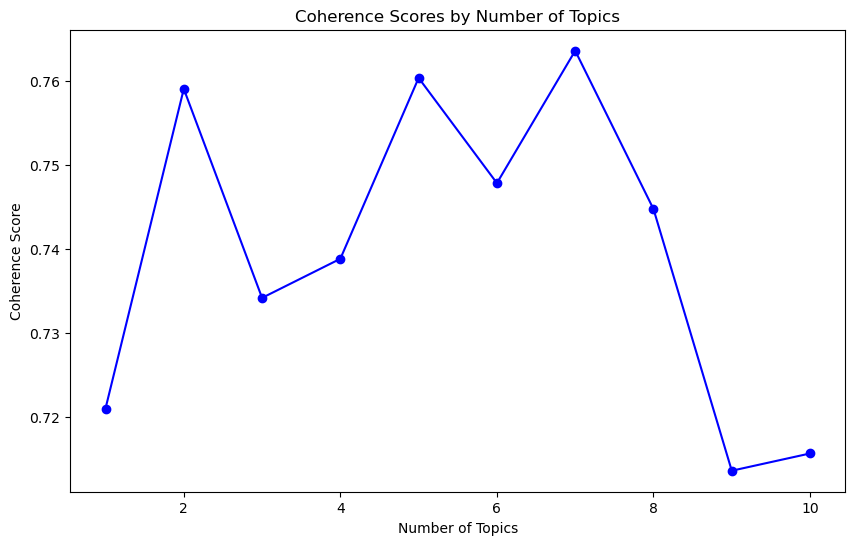

Best Number of Topics: 7 with Coherence Score: 0.7635773058132608


In [11]:
name_ingredients_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_name_ingredients'],  CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.598958548467784
Number of Topics: 2, Coherence Score: 0.6417957654443414
Number of Topics: 3, Coherence Score: 0.6138289396369669
Number of Topics: 4, Coherence Score: 0.5941644817682435
Number of Topics: 5, Coherence Score: 0.5729017001829603
Number of Topics: 6, Coherence Score: 0.585912442101118
Number of Topics: 7, Coherence Score: 0.5857591698660026
Number of Topics: 8, Coherence Score: 0.5829497838643367
Number of Topics: 9, Coherence Score: 0.5913081512449785
Number of Topics: 10, Coherence Score: 0.5774278322460027


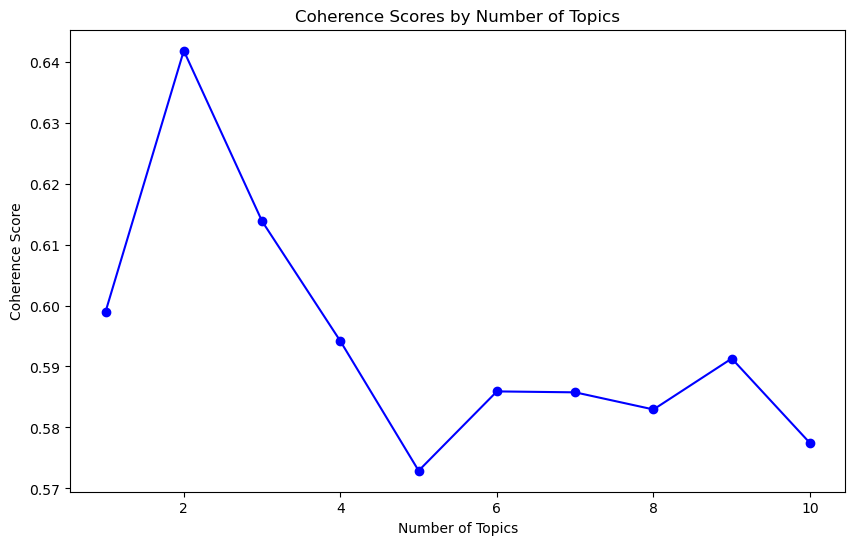

Best Number of Topics: 2 with Coherence Score: 0.6417957654443414


In [12]:
all_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_all_contexts'],  CountVectorizer(), range(1, 11, 1))

Choose the model with the highest coherence score for more explorations

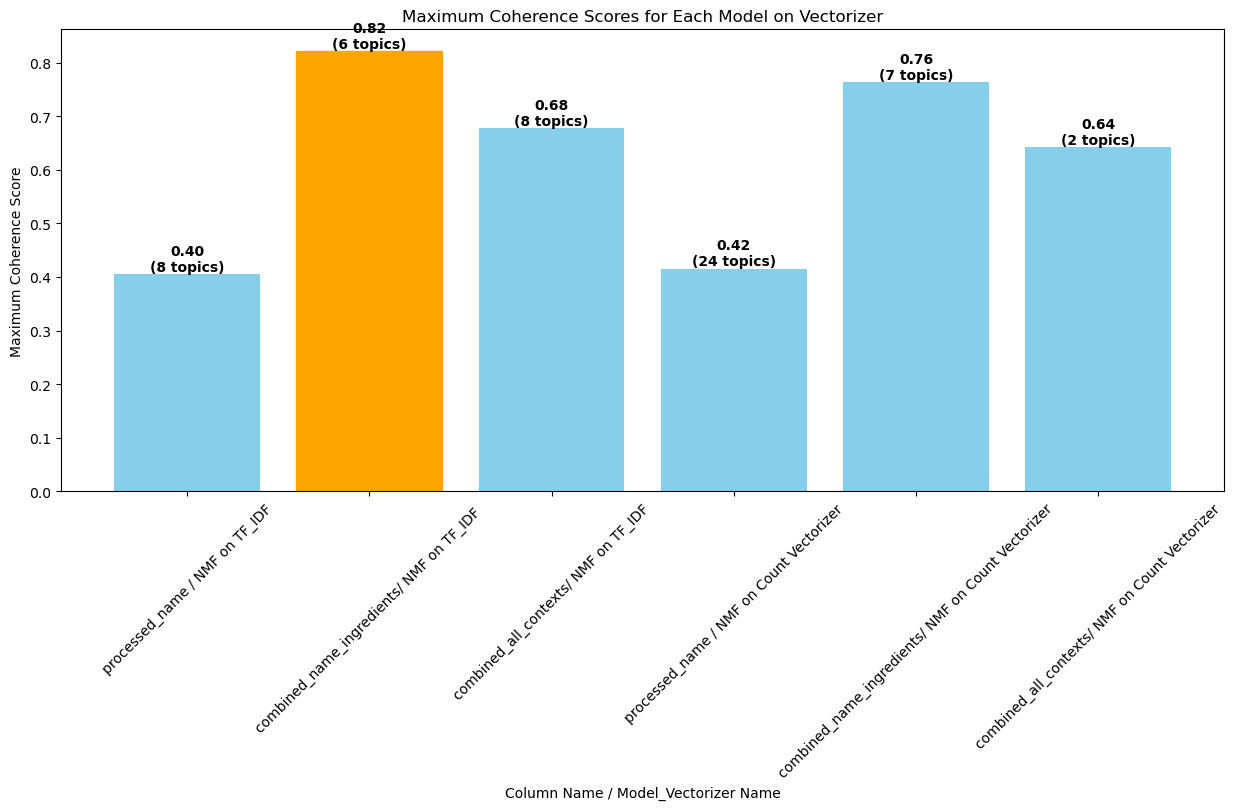

In [ ]:
coherence_scores_dict = {"processed_name / NMF on TF_IDF": name_coherence_scores_nmf_tfidf[0],
    "combined_name_ingredients/ NMF on TF_IDF ": name_ingredients_coherence_scores_nmf_tfidf[0],
    "combined_all_contexts/ NMF on TF_IDF": all_coherence_scores_nmf_tfidf[0], 
    "processed_name / NMF on Count Vectorizer": name_coherence_scores_nmf_countvect[0],
    "combined_name_ingredients/ NMF on Count Vectorizer": name_ingredients_coherence_scores_nmf_countvect[0],
    "combined_all_contexts/ NMF on Count Vectorizer": all_coherence_scores_nmf_countvect[0]}

# Best topic numbers
best_num_topics = [name_coherence_scores_nmf_tfidf[1], name_ingredients_coherence_scores_nmf_tfidf[1], all_coherence_scores_nmf_tfidf[1],
    name_coherence_scores_nmf_countvect[1], name_ingredients_coherence_scores_nmf_countvect[1], all_coherence_scores_nmf_countvect[1]]

# Extract coherence scores and assign best topics
labels = list(coherence_scores_dict.keys())
max_scores = [max(scores) for scores in coherence_scores_dict.values()]
best_topics_for_each = [best_num_topics[i] for i in range(len(labels))]

plt.figure(figsize=(15, 6))
bars = plt.bar(labels, max_scores, color='skyblue')

# Highlight the bar with the highest coherence score
max_index = max_scores.index(max(max_scores))
bars[max_index].set_color('orange')

# Annotate each bar with the coherence score and best topic count
for bar, score, topics in zip(bars, max_scores, best_topics_for_each):
    plt.text(bar.get_x() + bar.get_width() / 2, score, f'{score:.2f}\n({topics} topics)', 
             ha='center', va='bottom', fontweight='bold', color='black')

plt.xlabel("Column Name / Model_Vectorizer Name")
plt.ylabel("Maximum Coherence Score")
plt.title("Maximum Coherence Scores for NMF Models on TF-IDF and Count Vectorizers")
plt.xticks(rotation=45)

plt.show()

A- Display the top words for each topic in the best NMF model

In [ ]:
best_num_topics = 6
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['combined_name_ingredients'])

# Train NMF model with the optimal number of topics
nmf_model = NMF(n_components=best_num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# Get the feature names (vocabulary) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

num_top_words = 20  
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

Topic 1: powder coriander dhania masala chilli jeera cumin turmeric haldi garam red ginger green onion aloo salt potato garlic seeds oil leave sabzi paneer flour paste besan amchur methi yogurt homemade
Topic 2: dal split urad chana bengal moong white gram toor arhar rice asafoetida hing green yellow ghee chilli whole idli dry curry salt seeds jeera cumin masoor kadugu dosa ginger lentil
Topic 3: pepper bell olive capsicum virgin extra green cheese black sauce garlic onion carrot oil corn salt gajjar bean lemon red pasta leave mushroom spring chicken basil chilli juice whole vegetable
Topic 4: flour sugar milk whole wheat maida purpose water ghee almond badam butter powder elaichi cardamom egg vanilla saffron chocolate extract strand nut pistachio rava rice sooji salt bread caster banana
Topic 5: cardamom elaichi cinnamon dalchini stick clove laung pod bay tej patta seed leaf black rice ghee peppercorn ginger mutton chicken fennel onion badi basmati pulao saunf nut garlic paste pudina


B- Plot the topic distribution for the best NMF model

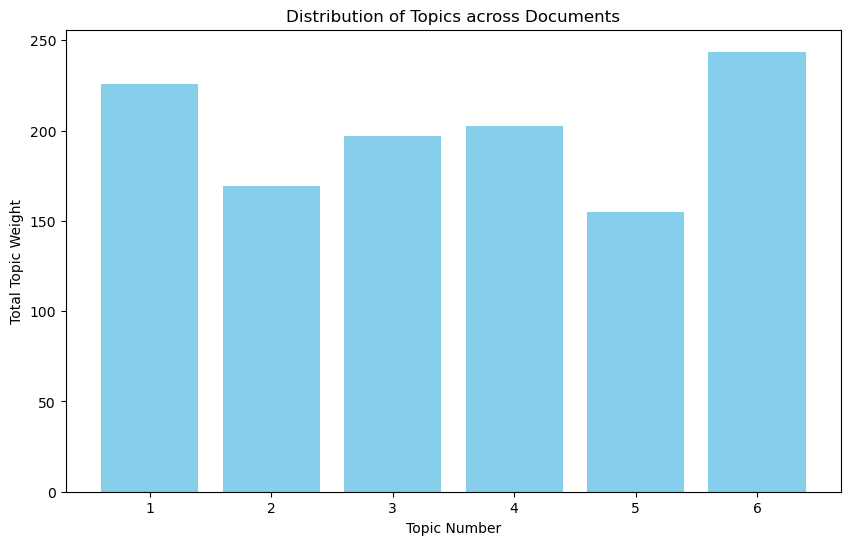

In [15]:
best_num_topics = 6
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['combined_name_ingredients'])

# Train the NMF model with the optimal number of topics
nmf_model = NMF(n_components=best_num_topics, random_state=42)
topic_matrix = nmf_model.fit_transform(tfidf_matrix)

# Sum the topic weights across all documents for each topic
topic_distribution = np.sum(topic_matrix, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(range(1, best_num_topics + 1), topic_distribution, color='skyblue')
plt.xlabel("Topic Number")
plt.ylabel("Total Topic Weight")
plt.title("Distribution of Topics across Documents")
plt.xticks(range(1, best_num_topics + 1))  # Label each topic
plt.show()

C- Plot the word cloud for the best NMF model

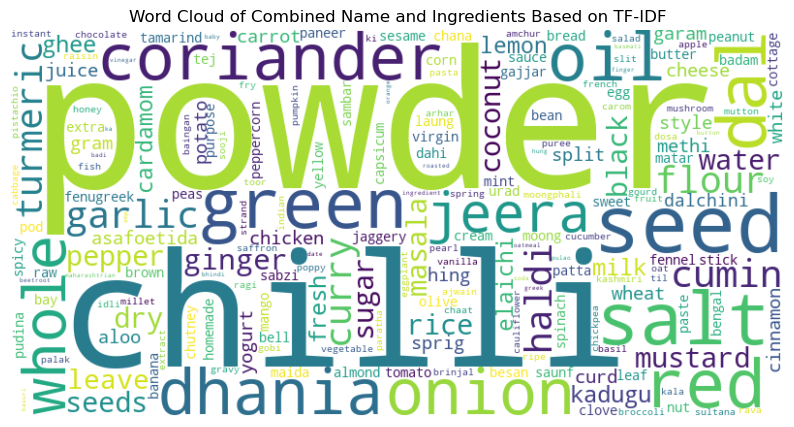

In [16]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_df['combined_name_ingredients'])

# Get the feature names (words) and their corresponding TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Sum TF-IDF scores across all documents 

# Create a dictionary of words and their TF-IDF scores
word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Combined Name and Ingredients Based on TF-IDF")
plt.show()

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,garam,haldi,turmeric,cumin,jeera,chilli,masala,dhania,coriander,powder
Topic 2,arhar,toor,gram,white,moong,bengal,chana,urad,split,dal
Topic 3,sauce,black,cheese,green,extra,virgin,capsicum,olive,bell,pepper
Topic 4,almond,ghee,water,purpose,maida,wheat,whole,milk,sugar,flour
Topic 5,tej,bay,pod,laung,clove,stick,dalchini,cinnamon,elaichi,cardamom
Topic 6,red,fresh,tamarind,chilli,dry,coconut,kadugu,curry,mustard,seed


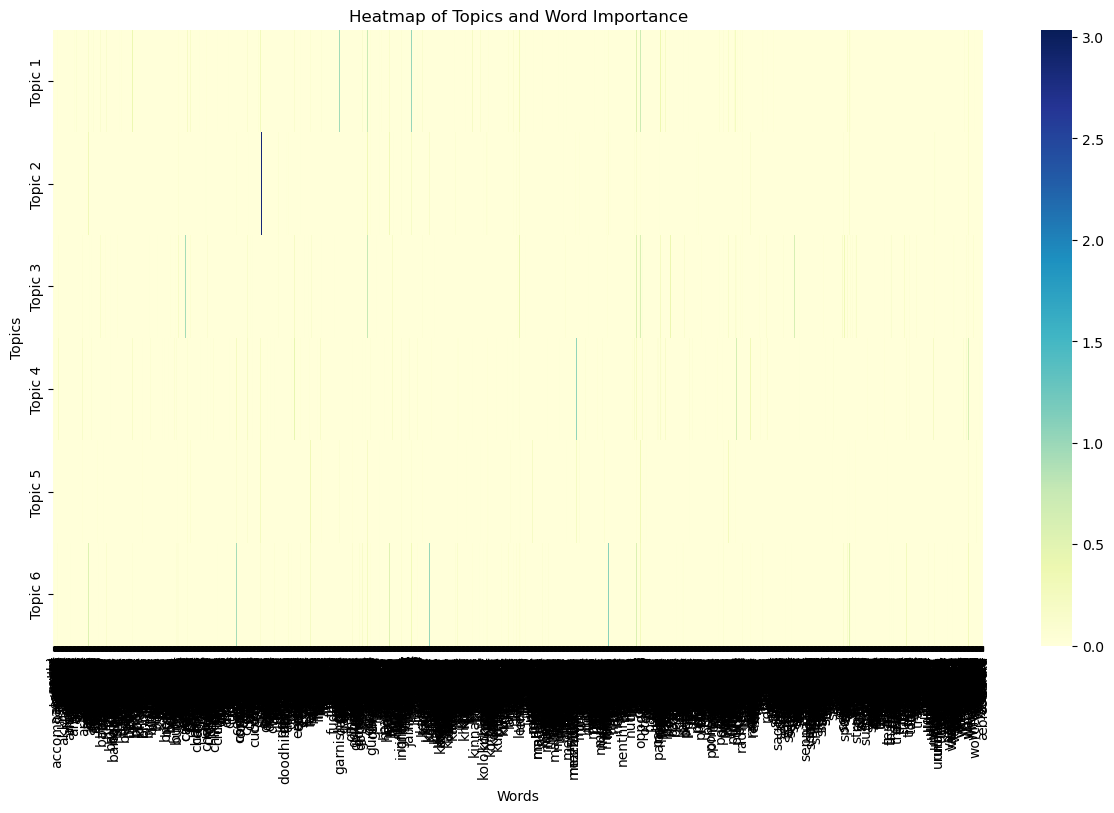

In [38]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define parameters
best_num_topics = 6
top_words_per_topic = 10

# Vectorize the text and apply NMF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_df['combined_name_ingredients'])
nmf_model = NMF(n_components=best_num_topics, random_state=42)
topic_matrix = nmf_model.fit_transform(tfidf_matrix)

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Extract top words for each topic
top_words_matrix = np.array([np.array([feature_names[i] for i in topic.argsort()[-top_words_per_topic:]]) for topic in nmf_model.components_])

# Create a DataFrame to show the top words for each topic
top_words_df = pd.DataFrame(top_words_matrix, columns=[f"Word {i+1}" for i in range(top_words_per_topic)], index=[f"Topic {i+1}" for i in range(best_num_topics)])

# Display the DataFrame of top words
display(top_words_df)

# Plot the heatmap of the NMF components (topics vs words)
plt.figure(figsize=(15, 8))
sns.heatmap(nmf_model.components_, yticklabels=[f"Topic {i+1}" for i in range(best_num_topics)], xticklabels=feature_names, cmap="YlGnBu")
plt.xlabel("Words")
plt.ylabel("Topics")
plt.title("Heatmap of Topics and Word Importance")
plt.show()

In [42]:
topic_matrix.shape

(9496, 6)

In [44]:
topic_matrix[10:].round(2)

array([[0.04, 0.  , 0.01, 0.01, 0.04, 0.03],
       [0.  , 0.09, 0.  , 0.  , 0.  , 0.11],
       [0.  , 0.01, 0.04, 0.  , 0.15, 0.  ],
       ...,
       [0.  , 0.  , 0.01, 0.  , 0.01, 0.05],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.05],
       [0.  , 0.  , 0.03, 0.  , 0.01, 0.12]])

In [59]:
topic_matrix.argmax(axis=1)

array([3, 0, 0, ..., 5, 5, 5], dtype=int64)

In [71]:
tsne = TSNE(n_components=2, verbose=2, random_state=0, perplexity=5, learning_rate=85, init='pca')
tsne_embedding = tsne.fit_transform(topic_matrix)

#tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
#tsne_embedding['hue'] = topic_matrix.argmax(axis=1)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 9496 samples in 0.009s...
[t-SNE] Computed neighbors for 9496 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9496
[t-SNE] Computed conditional probabilities for sample 2000 / 9496
[t-SNE] Computed conditional probabilities for sample 3000 / 9496
[t-SNE] Computed conditional probabilities for sample 4000 / 9496
[t-SNE] Computed conditional probabilities for sample 5000 / 9496
[t-SNE] Computed conditional probabilities for sample 6000 / 9496
[t-SNE] Computed conditional probabilities for sample 7000 / 9496
[t-SNE] Computed conditional probabilities for sample 8000 / 9496
[t-SNE] Computed conditional probabilities for sample 9000 / 9496
[t-SNE] Computed conditional probabilities for sample 9496 / 9496
[t-SNE] Mean sigma: 0.003495
[t-SNE] Computed conditional probabilities in 0.053s
[t-SNE] Iteration 50: error = 109.4000778, gradient norm = 0.0363169 (50 iterations in 3.116s)
[t-SNE] Iteration 100:

In [72]:
tsne_embedding

array([[-23.959621 ,  -9.089313 ],
       [-36.288486 ,  49.829292 ],
       [ -7.8859463,  -6.85066  ],
       ...,
       [ 45.574905 ,  -3.4969778],
       [ 40.03437  ,  -3.7253683],
       [ 82.43282  ,  42.54202  ]], dtype=float32)

In [47]:
print(tsne_embedding.shape)

(9496, 3)


In [48]:
tsne_embedding.head()

,x,y,hue
0,-23.959621,-9.089313,3
1,-36.288486,49.829292,0
2,-7.885946,-6.850660,0
3,67.706230,49.491310,5
4,100.692123,10.886025,5


In [49]:

tsne_embedding.isnull().values.any()

False

In [50]:
tsne_embedding.hue.unique()

array([3, 0, 5, 4, 2, 1], dtype=int64)

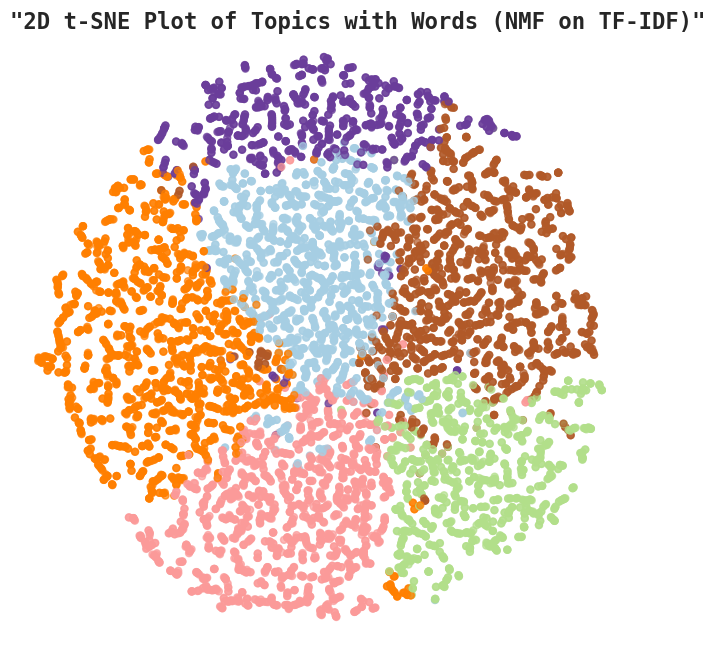

In [69]:
import matplotlib.pyplot as plt
#plt.rc('font',family='monospace')
#plt.style.use('seaborn-poster')

fig, axs = plt.subplots(1,1, figsize=(8, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

#data = tsne_embedding
scatter = plt.scatter(data=tsne_embedding,x='x',y='y',s=25, c=tsne_embedding['hue'], cmap="Paired", alpha=0.7)
plt.axis('off')
plt.annotate('"2D t-SNE Plot of Topics with Words (NMF on TF-IDF)"', xy=(0, 1), xycoords='axes fraction',
            fontsize = 16, weight = 'bold', alpha = .85)

plt.show()

         Word 1 Word 2    Word 3   Word 4 Word 5   Word 6    Word 7    Word 8  \
Topic 1   garam  haldi  turmeric    cumin  jeera   chilli    masala    dhania   
Topic 2   arhar   toor      gram    white  moong   bengal     chana      urad   
Topic 3   sauce  black    cheese    green  extra   virgin  capsicum     olive   
Topic 4  almond   ghee     water  purpose  maida    wheat     whole      milk   
Topic 5     tej    bay       pod    laung  clove    stick  dalchini  cinnamon   
Topic 6     red  fresh  tamarind   chilli    dry  coconut    kadugu     curry   

            Word 9   Word 10  
Topic 1  coriander    powder  
Topic 2      split       dal  
Topic 3       bell    pepper  
Topic 4      sugar     flour  
Topic 5    elaichi  cardamom  
Topic 6    mustard      seed  


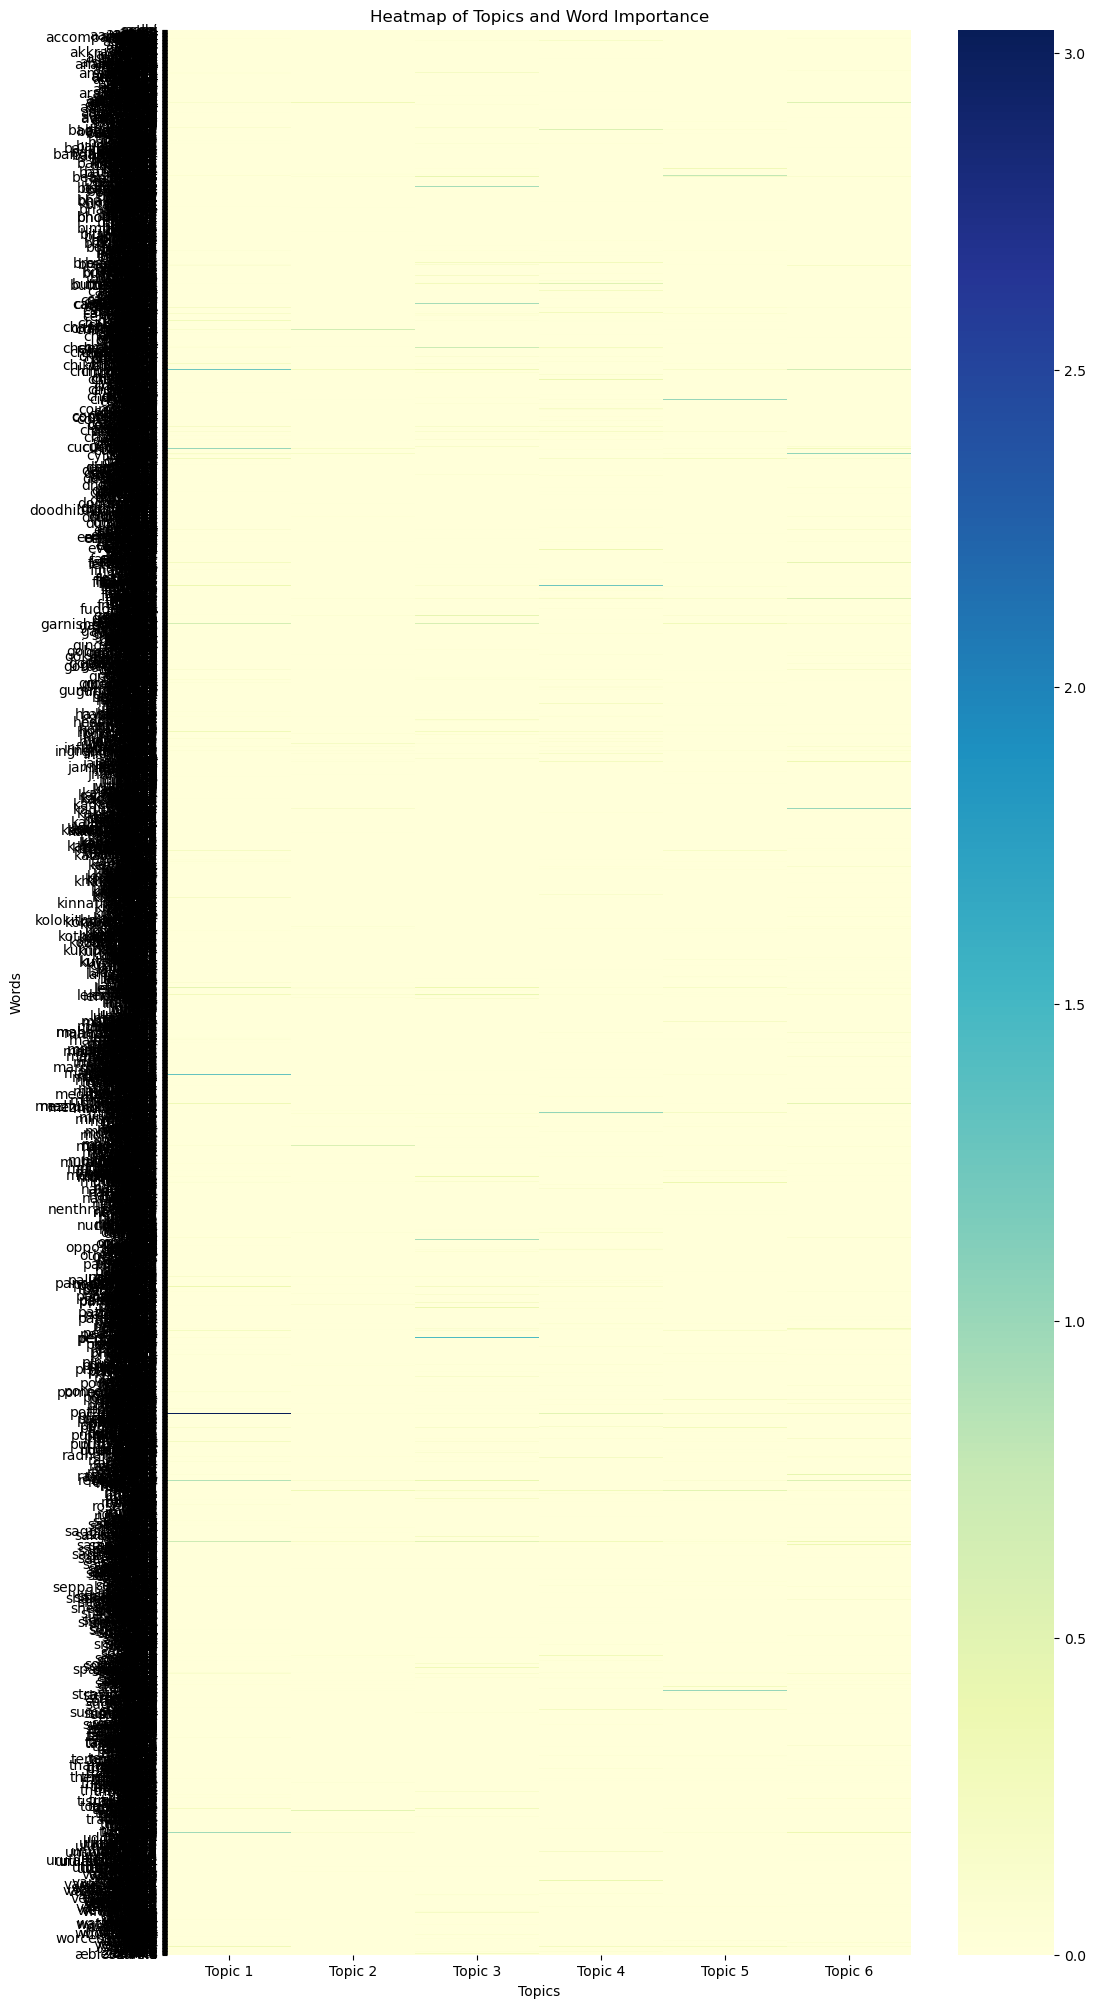

In [40]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define parameters
best_num_topics = 6
top_words_per_topic = 10

# Vectorize the text and apply NMF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_df['combined_name_ingredients'])
nmf_model = NMF(n_components=best_num_topics, random_state=42)
topic_matrix = nmf_model.fit_transform(tfidf_matrix)

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Extract top words for each topic
top_words_matrix = np.array([np.array([feature_names[i] for i in topic.argsort()[-top_words_per_topic:]]) for topic in nmf_model.components_])

# Create a DataFrame to show the top words for each topic
top_words_df = pd.DataFrame(top_words_matrix, columns=[f"Word {i+1}" for i in range(top_words_per_topic)], index=[f"Topic {i+1}" for i in range(best_num_topics)])

# Display the DataFrame of top words
print(top_words_df)

# Plot the heatmap of the NMF components (topics vs words)
plt.figure(figsize=(12, 25))
sns.heatmap(nmf_model.components_.T, yticklabels=feature_names, xticklabels=[f"Topic {i+1}" for i in range(best_num_topics)], cmap="YlGnBu")
plt.xlabel("Topics")
plt.ylabel("Words")
plt.title("Heatmap of Topics and Word Importance")
plt.show()